# Data Preparation

## Installing and importing modules

In [2393]:
pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [130]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read the dataset

In [131]:
print(os.path.exists("variant_1.csv"))

True


In [132]:
ds = pd.read_csv("variant_1.csv")

In [133]:
print('columns count - ',len(ds.columns), '\n')
print('columns: ',list(ds.columns))

columns count -  34 

columns:  ['Unnamed: 0', 'ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status']


In [134]:
print('Samples count: ', ds.shape[0])

Samples count:  148670


## Outlier Handling

In [135]:
# Let's define the function for finding the skewed boundaries

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [136]:
# Find the exact upper and lower limits for outliers for each column using the current IQR-based method

income_upper_limit, income_lower_limit = find_skewed_boundaries(ds, 'income', 4)
property_value_upper_limit, property_value_lower_limit = find_skewed_boundaries(ds, 'property_value', 2)

In [137]:
# Display boundaries for each column

boundaries = (income_upper_limit, income_lower_limit, 
              property_value_upper_limit, property_value_lower_limit)

boundaries

(27720.0, -15480.0, 1348000.0, -452000.0)

In [138]:
# Function to create a boxplot for visualizing outliers
def plot_boxplot(df, column, upper_limit, lower_limit, title):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.boxplot(df[column].dropna())
    plt.axhline(y=upper_limit, color='r', linestyle='--', label=f'Upper Limit: {upper_limit}')
    plt.axhline(y=lower_limit, color='g', linestyle='--', label=f'Lower Limit: {lower_limit}')
    plt.legend()
    plt.ylabel(column)
    plt.show()

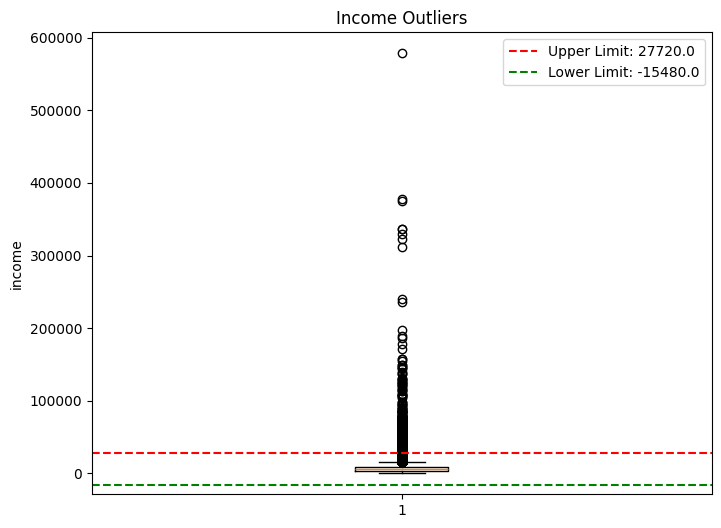

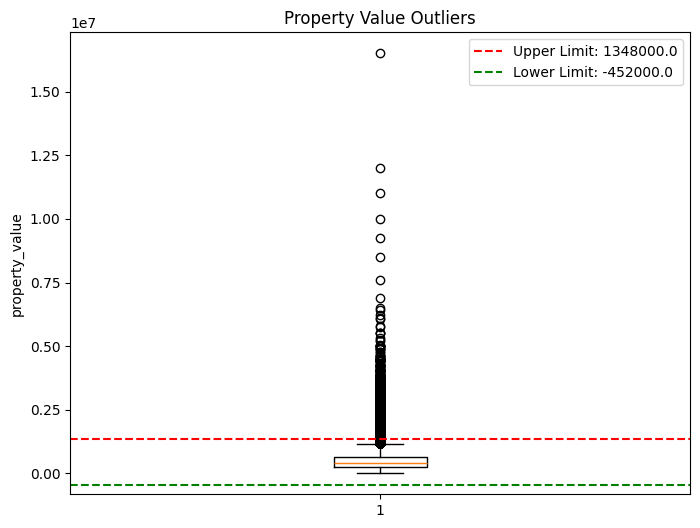

In [139]:
# Plot boxplots for 'income', 'rate_of_interest', and 'property_value'
plot_boxplot(ds, 'income', income_upper_limit, income_lower_limit, 'Income Outliers')
plot_boxplot(ds, 'property_value', property_value_upper_limit, property_value_lower_limit, 'Property Value Outliers')

In [140]:
# Count rows where values exceed the upper or lower limits for each column
income_outliers_count = ((ds['income'] > income_upper_limit) | (ds['income'] < income_lower_limit)).sum()
property_value_outliers_count = ((ds['property_value'] > property_value_upper_limit) | 
                                 (ds['property_value'] < property_value_lower_limit)).sum()

# Output the number of outliers for each column
outlier_counts_ds = {
    "income_outliers_count": income_outliers_count,
    "property_value_outliers_count": property_value_outliers_count
}

outlier_counts_ds

{'income_outliers_count': 1264, 'property_value_outliers_count': 3412}

In [141]:
# Adjusting the filtering logic to retain rows with missing values but remove only those with outliers

# Number of rows before removing outliers
initial_count = ds.shape[0]

# Remove rows where any of the conditions for outliers in income, rate_of_interest, or property_value are true,
# but retain rows with missing values
ds_less_aggressive_cleaned = ds[
    ((ds['income'].isnull()) | ((ds['income'] <= income_upper_limit) & (ds['income'] >= income_lower_limit))) &
    ((ds['property_value'].isnull()) | ((ds['property_value'] <= property_value_upper_limit) & (ds['property_value'] >= property_value_lower_limit)))
]

# Number of rows after removing only outliers and retaining missing values
final_count = ds_less_aggressive_cleaned.shape[0]

# Output the number of rows before and after removing outliers
initial_count, final_count



(148670, 144316)

In [142]:
ds[['income', 'property_value']].describe()

,income,property_value
count,139520.000000,1.335720e+05
mean,6957.338876,4.978935e+05
std,6496.586382,3.599353e+05
min,0.000000,8.000000e+03
25%,3720.000000,2.680000e+05
50%,5760.000000,4.180000e+05
75%,8520.000000,6.280000e+05
max,578580.000000,1.650800e+07


In [143]:
ds = ds_less_aggressive_cleaned
ds[['income', 'property_value']].describe()

,income,property_value
count,135220.000000,1.293700e+05
mean,6471.938027,4.588166e+05
std,3967.792976,2.476191e+05
min,0.000000,8.000000e+03
25%,3660.000000,2.680000e+05
50%,5640.000000,4.080000e+05
75%,8280.000000,6.080000e+05
max,27720.000000,1.348000e+06


In [144]:
# Replacing values where LTV is greater than 100 with 100
ds['LTV'] = ds['LTV'].apply(lambda x: 100 if x > 100 else x)

# Checking how many rows were affected
print(f"Number of rows where LTV was greater than 100: {(ds['LTV'] > 100).sum()}")

Number of rows where LTV was greater than 100: 0


In [145]:
ds[['LTV']].describe()

,LTV
count,129370.000000
mean,73.336427
std,17.837868
min,4.319572
25%,62.126866
50%,75.568182
75%,86.726804
max,100.000000


## Missing data imputation

In [146]:
ds.shape

(144316, 34)

In [147]:
missing = []

for x in ds.columns:
    if ds[x].isnull().sum() != 0:
        print(x, ds[x].isnull().sum())
        missing.append(x)

loan_limit 3278
approv_in_adv 882
loan_purpose 132
rate_of_interest 35464
Interest_rate_spread 35663
Upfront_charges 38444
term 37
Neg_ammortization 114
property_value 14946
income 9096
age 199
submission_of_application 199
LTV 14946


In [148]:
# function to fill missing values:
# function takes the dataframe, the variable, and the value for imputation
# and returns the variable filled with the specified value


def impute_na(df, variable, value):

    return df[variable].fillna(value)

### Mode imputation

In [149]:
# Check all columns and select only those that are objects or categorical (non-numeric)
categorical_columns = ds.select_dtypes(include=['object']).columns

# Create a loop to display unique values, their counts, and the number of missing values for each categorical column
for col in categorical_columns:
    print(f"Unique values in the column '{col}':")
    print(ds[col].value_counts())
    print(f"Missing values: {ds[col].isnull().sum()}")
    print("\n" + "-"*50 + "\n")


Unique values in the column 'loan_limit':
loan_limit
cf     132407
ncf      8631
Name: count, dtype: int64
Missing values: 3278

--------------------------------------------------

Unique values in the column 'Gender':
Gender
Male                 41200
Joint                39582
Sex Not Available    36792
Female               26742
Name: count, dtype: int64
Missing values: 0

--------------------------------------------------

Unique values in the column 'approv_in_adv':
approv_in_adv
nopre    120836
pre       22598
Name: count, dtype: int64
Missing values: 882

--------------------------------------------------

Unique values in the column 'loan_type':
loan_type
type1    108954
type2     20748
type3     14614
Name: count, dtype: int64
Missing values: 0

--------------------------------------------------

Unique values in the column 'loan_purpose':
loan_purpose
p3    54471
p4    52795
p1    33849
p2     3069
Name: count, dtype: int64
Missing values: 132

-------------------------------

In [150]:
# function to fill missing values:
# function takes the dataframe, the variable, and the value for imputation
# and returns the variable filled with the specified value


def impute_na(df, variable, value):

    return df[variable].fillna(value)


In [151]:
# calculate the mode loan_limit

mode_loan_limit = ds['loan_limit'].mode()[0]
mode_loan_limit

'cf'

In [152]:
#  replace with the mode
ds['loan_limit'] = impute_na(ds, 'loan_limit', mode_loan_limit)

In [153]:
# calculate the mode approv_in_adv

mode_approv_in_adv = ds['approv_in_adv'].mode()[0]
mode_approv_in_adv

'nopre'

In [154]:
ds['approv_in_adv'] = impute_na(ds, 'approv_in_adv', mode_approv_in_adv)

In [155]:
# calculate the mode loan_purpose

mode_loan_purpose = ds['loan_purpose'].mode()[0]
mode_loan_purpose

'p3'

In [156]:
ds['loan_purpose'] = impute_na(ds, 'loan_purpose', mode_loan_purpose)

In [157]:
# calculate the mode Neg_ammortization

mode_Neg_ammortization = ds['Neg_ammortization'].mode()[0]
mode_Neg_ammortization

'not_neg'

In [158]:
ds['Neg_ammortization'] = impute_na(ds, 'Neg_ammortization', mode_Neg_ammortization)

In [159]:
# calculate the mode submission_of_application

mode_submission_of_application = ds['submission_of_application'].mode()[0]
mode_submission_of_application

'to_inst'

In [160]:
ds['submission_of_application'] = impute_na(ds, 'submission_of_application', mode_submission_of_application)

In [161]:
# calculate the mode age

mode_age = ds['age'].mode()[0]
mode_age

'45-54'

In [162]:
ds['age'] = impute_na(ds, 'age', mode_age)

In [163]:
# calculate the mode Security_Type

mode_Security_Type = ds['Security_Type'].mode()[0]
mode_Security_Type

'direct'

In [164]:
ds['Security_Type'] = impute_na(ds, 'Security_Type', mode_Security_Type)

In [165]:
missing = []

# Select only categorical columns
categorical_columns = ds.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if ds[col].isnull().sum() != 0:
        print(col, ds[col].isnull().sum())
        missing.append(col)

if not missing:
    print("No missing values in categorical columns.")


No missing values in categorical columns.


### Median imputation by category

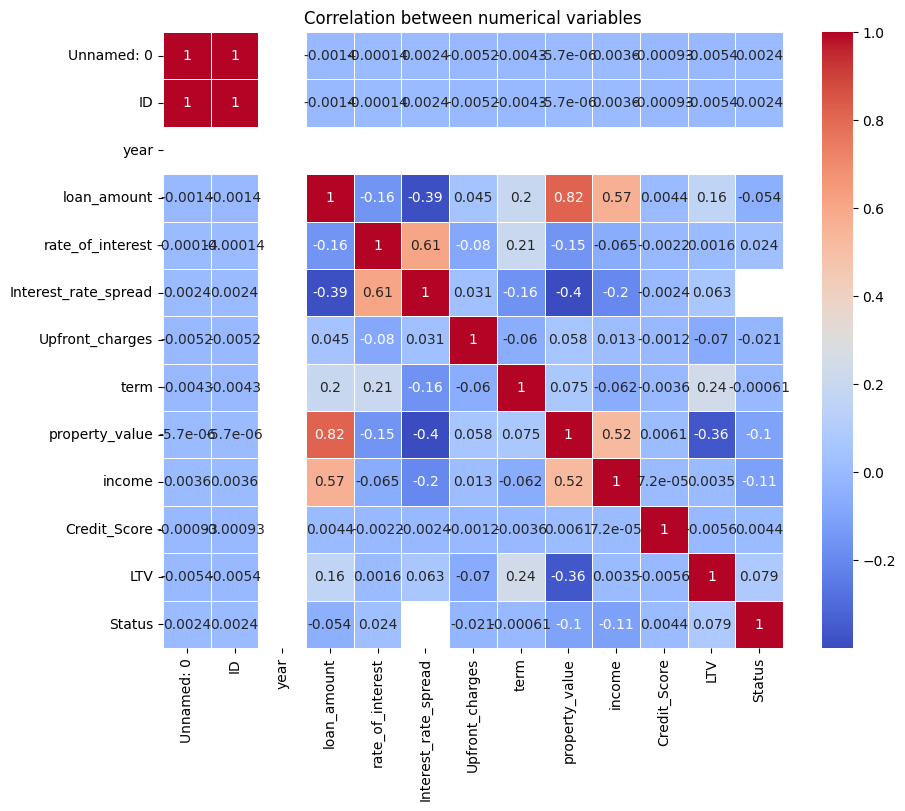

In [166]:
# Selecting only numerical columns
numeric_data = ds.select_dtypes(include=['float64', 'int64'])

# Calculating the correlation matrix for numerical columns
correlation_matrix = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between numerical variables')
plt.show()

In [167]:
missing_numeric = []

for x in ds.select_dtypes(include=['float64', 'int64']).columns:
    if ds[x].isnull().sum() != 0:
        print(x, ds[x].isnull().sum())
        missing_numeric.append(x)


rate_of_interest 35464
Interest_rate_spread 35663
Upfront_charges 38444
term 37
property_value 14946
income 9096
LTV 14946


In [168]:
# function to fill missing values:
# function takes the dataframe, the variable, and the value for imputation
# and returns the variable filled with the specified value


def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [169]:
specific_columns = ['rate_of_interest', 'Interest_rate_spread']
ds[specific_columns].describe()

,rate_of_interest,Interest_rate_spread
count,108852.000000,108653.000000
mean,4.046801,0.448800
std,0.556017,0.512659
min,0.000000,-3.638000
25%,3.625000,0.084600
50%,3.990000,0.398500
75%,4.375000,0.784000
max,8.000000,3.357000


In [170]:
# Set ranges for Interest_rate_spread
bins_spread = [-np.inf, 0, 2, np.inf] 
labels_spread = ['Negative', 'Low', 'High']  

# Create a new category for Interest_rate_spread, including NaN as its own category
ds['spread_category'] = pd.cut(ds['Interest_rate_spread'], bins=bins_spread, labels=labels_spread)

ds['spread_category'] = ds['spread_category'].cat.add_categories(['Missing'])
ds['spread_category'].fillna('Missing', inplace=True)

median_interest_by_spread_category = ds.groupby('spread_category')['rate_of_interest'].median()

print("Median interest by category:")
print(median_interest_by_spread_category)

Median interest by category:
spread_category
Negative    3.500
Low         4.000
High        6.750
Missing     4.375
Name: rate_of_interest, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_11716\2012594908.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ds['spread_category'].fillna('Missing', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_11716\2012594908.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_interest_by_spread_category = ds.groupby('spread_categ

In [171]:
# Replacing missing values with the median for the corresponding category
for category in median_interest_by_spread_category.index:
    # Select rows with the corresponding category and missing values in rate_of_interest
    category_rows = (ds['spread_category'] == category) & (ds['rate_of_interest'].isnull())
    
    # Fill missing values only for these rows
    ds.loc[category_rows, 'rate_of_interest'] = impute_na(ds.loc[category_rows], 'rate_of_interest', median_interest_by_spread_category[category])

print("Total missing values after processing:")
print(ds['rate_of_interest'].isnull().sum())


Total missing values after processing:
0


In [172]:
ds = ds.drop(columns=['spread_category'])

In [173]:
specific_columns = ['rate_of_interest', 'Interest_rate_spread']
ds[specific_columns].describe()

,rate_of_interest,Interest_rate_spread
count,144316.000000,108653.000000
mean,4.127452,0.448800
std,0.503138,0.512659
min,0.000000,-3.638000
25%,3.750000,0.084600
50%,4.250000,0.398500
75%,4.375000,0.784000
max,8.000000,3.357000


In [174]:
# Set ranges for rate_of_interest
bins_interest = [-np.inf, 2, 5, np.inf] 
labels_interest = ['Low', 'Medium', 'High'] 

# Create a new category for rate_of_interest
ds['interest_category'] = pd.cut(ds['rate_of_interest'], bins=bins_interest, labels=labels_interest)

# Calculate the median value of Interest_rate_spread for each interest_category
median_spread_by_interest_category = ds.groupby('interest_category')['Interest_rate_spread'].median()

print("Median spread by interest category:")
median_spread_by_interest_category

Median spread by interest category:


C:\Users\user\AppData\Local\Temp\ipykernel_11716\3950656722.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spread_by_interest_category = ds.groupby('interest_category')['Interest_rate_spread'].median()


interest_category
Low      -3.6380
Medium    0.3796
High      1.2995
Name: Interest_rate_spread, dtype: float64

In [175]:
# Replacing missing values with the median for the corresponding category
for category in median_spread_by_interest_category.index:
    category_rows = (ds['interest_category'] == category) & (ds['Interest_rate_spread'].isnull())
    
    ds.loc[category_rows, 'Interest_rate_spread'] = impute_na(ds.loc[category_rows], 'Interest_rate_spread', median_spread_by_interest_category[category])

print("Total missing values in Interest_rate_spread after processing:")
print(ds['Interest_rate_spread'].isnull().sum())

Total missing values in Interest_rate_spread after processing:
0


In [176]:
ds = ds.drop(columns=['interest_category'])

In [177]:
# Calculate the median of the 'term' column
median_value = ds['term'].median()
median_value

360.0

In [178]:
# Replace missing values with the median
ds['term'] = impute_na(ds, 'term', median_value)

In [179]:
# Set ranges for loan_amount
bins_loan = [0, 200000, 300000, 500000, np.inf]  
labels_loan = ['Small', 'Medium', 'Large', 'Jumbo'] 

ds['loan_category'] = pd.cut(ds['loan_amount'], bins=bins_loan, labels=labels_loan)

median_property_by_loan_category = ds.groupby('loan_category')['property_value'].median()

print("Median property value by loan category:")
median_property_by_loan_category

Median property value by loan category:


C:\Users\user\AppData\Local\Temp\ipykernel_11716\383675521.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_property_by_loan_category = ds.groupby('loan_category')['property_value'].median()


loan_category
Small     208000.0
Medium    328000.0
Large     518000.0
Jumbo     778000.0
Name: property_value, dtype: float64

In [180]:
# Replacing missing values in property values with the median for the corresponding category
for category in median_property_by_loan_category.index:
    category_rows = (ds['loan_category'] == category) & (ds['property_value'].isnull())
    
    ds.loc[category_rows, 'property_value'] = median_property_by_loan_category[category]

print("Total missing values in property_value after processing:")
print(ds['property_value'].isnull().sum())

Total missing values in property_value after processing:
0


In [181]:
# Categorization of property_value based on quartiles and maximum values
bins_property_value = [0, 270000, 480000, 680000, np.inf]  
labels_property_value = ['Low', 'Medium', 'High', 'Very High']  

# Create a new category for property_value
ds['property_category'] = pd.cut(ds['property_value'], bins=bins_property_value, labels=labels_property_value)

# Calculate the median LTV value for each property_value category
median_ltv_by_property_category = ds.groupby('property_category')['LTV'].median()

print("Median LTV by property category:")
print(median_ltv_by_property_category)

Median LTV by property category:
property_category
Low          81.250000
Medium       78.110048
High         74.641577
Very High    62.775551
Name: LTV, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_11716\4204712805.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_ltv_by_property_category = ds.groupby('property_category')['LTV'].median()


In [182]:
# Filling missing LTV values with the median value for the corresponding property_category
for category in median_ltv_by_property_category.index:
    # Select rows with the corresponding category and missing values in LTV
    category_rows = (ds['property_category'] == category) & (ds['LTV'].isnull())
    
    # Fill missing values with the median for the corresponding category
    ds.loc[category_rows, 'LTV'] = median_ltv_by_property_category[category]

print("Total missing values in LTV after processing:")
print(ds['LTV'].isnull().sum())

Total missing values in LTV after processing:
0


In [183]:
ds = ds.drop(columns=['property_category'])

In [184]:
# Categorization of loan_amount
bins_loan = [0, 200000, 300000, 500000, np.inf]  # Set ranges for loan_amount
labels_loan = ['Small', 'Medium', 'Large', 'Jumbo']  # Label each category

# Create a new category for loan_amount
ds['loan_category'] = pd.cut(ds['loan_amount'], bins=bins_loan, labels=labels_loan)

# Calculate the median income for each loan_category
median_income_by_loan_category = ds.groupby('loan_category')['income'].median()

print("Median income by loan category:")
print(median_income_by_loan_category)

Median income by loan category:
loan_category
Small     3300.0
Medium    4860.0
Large     6840.0
Jumbo     9480.0
Name: income, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_11716\3977123537.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_income_by_loan_category = ds.groupby('loan_category')['income'].median()


In [185]:
# Replacing missing values in income with the median value for the corresponding loan_category
for category in median_income_by_loan_category.index:
    # Select rows with the corresponding category and missing values in income
    category_rows = (ds['loan_category'] == category) & (ds['income'].isnull())
    
    # Fill missing values with the median for the corresponding category
    ds.loc[category_rows, 'income'] = median_income_by_loan_category[category]

# Check the number of missing values after filling
print("Total missing values in income after processing:")
print(ds['income'].isnull().sum())

Total missing values in income after processing:
0


In [186]:
ds = ds.drop(columns=['loan_category'])

In [187]:
missing_numeric = []

for x in ds.select_dtypes(include=['float64', 'int64']).columns:
    if ds[x].isnull().sum() != 0:
        print(x, ds[x].isnull().sum())
        missing_numeric.append(x)

Upfront_charges 38444


### Random imputation

In [188]:
# Randomly replacing missing values with existing ones
ds['Upfront_charges'] = ds['Upfront_charges'].apply(
    lambda x: np.random.choice(ds['Upfront_charges'].dropna()) if pd.isnull(x) else x
)

# Check how many missing values are left
missing_values = ds['Upfront_charges'].isnull().sum()

print(f"Number of missing values in 'Upfront_charges': {missing_values}")

Number of missing values in 'Upfront_charges': 0


In [189]:
ds[['Upfront_charges']].describe()

,Upfront_charges
count,144316.000000
mean,3213.186457
std,3164.703242
min,0.000000
25%,618.190000
50%,2629.945000
75%,4806.250000
max,33268.000000


In [190]:
ds[['term']].describe()

,term
count,144316.000000
mean,335.287723
std,58.178224
min,96.000000
25%,360.000000
50%,360.000000
75%,360.000000
max,360.000000


In [191]:
missing_numeric = []

# Перевіряємо лише числові стовпці
for x in ds.select_dtypes(include=['float64', 'int64']).columns:
    if ds[x].isnull().sum() != 0:
        print(x, ds[x].isnull().sum())
        missing_numeric.append(x)

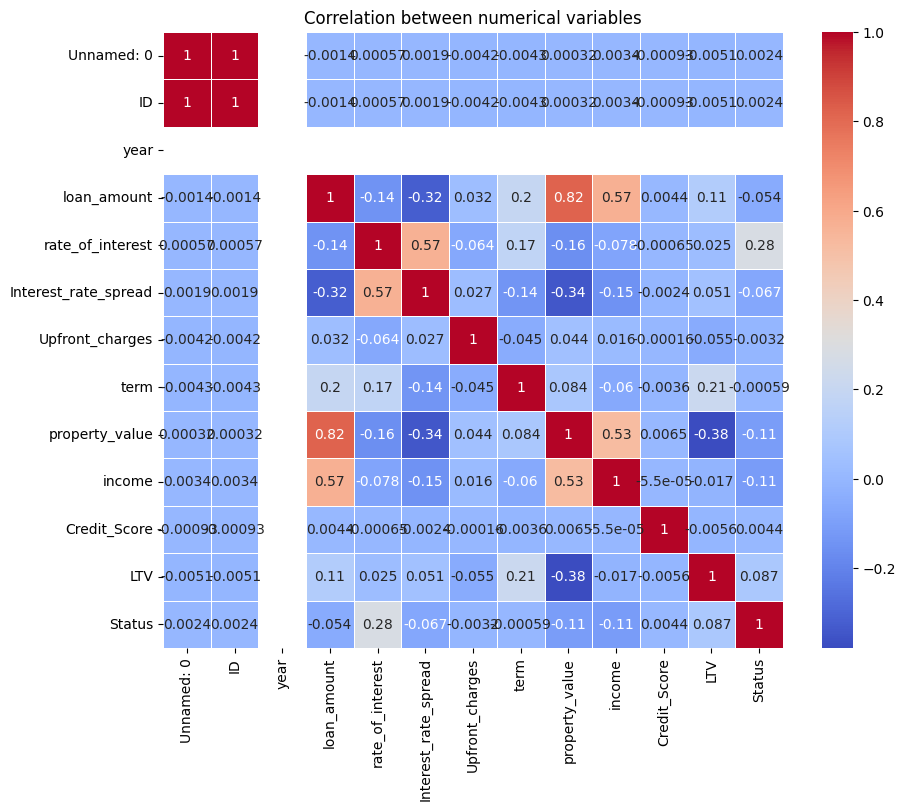

In [192]:
# Selecting only numerical columns
numeric_data = ds.select_dtypes(include=['float64', 'int64'])

# Calculating the correlation matrix for numerical columns
correlation_matrix = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between numerical variables')
plt.show()

## Categorical encoding

In [193]:
# Checking the number of unique values only for categorical columns
categorical_columns = ds.select_dtypes(include=['object']).columns
unique_values_in_categoricals = ds[categorical_columns].nunique()

unique_values_in_categoricals

loan_limit                   2
Gender                       4
approv_in_adv                2
loan_type                    3
loan_purpose                 4
Credit_Worthiness            2
open_credit                  2
business_or_commercial       2
Neg_ammortization            2
interest_only                2
lump_sum_payment             2
construction_type            2
occupancy_type               3
Secured_by                   2
total_units                  4
credit_type                  4
co-applicant_credit_type     2
age                          7
submission_of_application    2
Region                       4
Security_Type                2
dtype: int64

### Binary Encoding

In [194]:
# loan_limit  has 2 labels

ds['loan_limit'].unique()

array(['cf', 'ncf'], dtype=object)

In [195]:
# Binary Encoding for loan_limit
ds['loan_limit'] = ds['loan_limit'].map({'cf': 0, 'ncf': 1})

# result
ds['loan_limit'].unique()

array([0, 1], dtype=int64)

In [196]:
# approv_in_adv  has 2 labels

ds['approv_in_adv'].unique()

array(['nopre', 'pre'], dtype=object)

In [197]:
# Binary Encoding for approv_in_adv
ds['approv_in_adv'] = ds['approv_in_adv'].map({'pre': 1, 'nopre': 0})


print(ds['approv_in_adv'].unique())

[0 1]


In [198]:
# Credit_Worthiness  has 2 labels

ds['Credit_Worthiness'].unique() 

array(['l1', 'l2'], dtype=object)

In [199]:
# Binary Encoding for Credit_Worthiness
ds['Credit_Worthiness'] = ds['Credit_Worthiness'].map({'l1': 0, 'l2': 1})

ds['Credit_Worthiness'].unique()

array([0, 1], dtype=int64)

In [200]:
# Credit_Worthiness has 2 labels

ds['open_credit'].unique() 

array(['nopc', 'opc'], dtype=object)

In [201]:
# Binary Encoding for open_credit
ds['open_credit'] = ds['open_credit'].map({'nopc': 0, 'opc': 1})

ds['open_credit'].unique()

array([0, 1], dtype=int64)

In [202]:
# Neg_ammortization has 2 labels

ds['Neg_ammortization'].unique() 

array(['not_neg', 'neg_amm'], dtype=object)

In [203]:
# Binary Encoding for Neg_ammortization
ds['Neg_ammortization'] = ds['Neg_ammortization'].map({'not_neg': 0, 'neg_amm': 1})

ds['Neg_ammortization'].unique()

array([0, 1], dtype=int64)

In [204]:
# interest_only has 2 labels

ds['interest_only'].unique() 

array(['not_int', 'int_only'], dtype=object)

In [205]:
# Binary Encoding for interest_only
ds['interest_only'] = ds['interest_only'].map({'not_int': 0, 'int_only': 1})

ds['interest_only'].unique()

array([0, 1], dtype=int64)

In [206]:
# lump_sum_payment has 2 labels

ds['lump_sum_payment'].unique()

array(['not_lpsm', 'lpsm'], dtype=object)

In [207]:
# Binary Encoding for lump_sum_payment
ds['lump_sum_payment'] = ds['lump_sum_payment'].map({'not_lpsm': 0, 'lpsm': 1})

ds['lump_sum_payment'].unique()

array([0, 1], dtype=int64)

In [208]:
# construction_type has 2 labels

ds['construction_type'].unique()

array(['sb', 'mh'], dtype=object)

In [209]:
# Binary Encoding for construction_type
ds['construction_type'] = ds['construction_type'].map({'sb': 0, 'mh': 1})

ds['construction_type'].unique()

array([0, 1], dtype=int64)

In [210]:
# co-applicant_credit_type  has 2 labels

ds['co-applicant_credit_type'].unique()

array(['CIB', 'EXP'], dtype=object)

In [211]:
# Binary Encoding for co-applicant_credit_type
ds['co-applicant_credit_type'] = ds['co-applicant_credit_type'].map({'CIB': 0, 'EXP': 1})

ds['co-applicant_credit_type'].unique()

array([0, 1], dtype=int64)

In [212]:
# business_or_commercial  has 2 labels

ds['business_or_commercial'].unique()

array(['nob/c', 'b/c'], dtype=object)

In [213]:
# Binary Encoding for business_or_commercial
ds['business_or_commercial'] = ds['business_or_commercial'].map({'nob/c': 0, 'b/c': 1})

ds['business_or_commercial'].unique()

array([0, 1], dtype=int64)

In [214]:
# Secured_by  has 2 labels

ds['Secured_by'].unique()

array(['home', 'land'], dtype=object)

In [215]:
# Binary Encoding for Secured_by
ds['Secured_by'] = ds['Secured_by'].map({'home': 0, 'land': 1})

ds['Secured_by'].unique()

array([0, 1], dtype=int64)

In [216]:
# submission_of_application has 2 labels

ds['submission_of_application'].unique()

array(['to_inst', 'not_inst'], dtype=object)

In [217]:
# Binary Encoding for submission_of_application
ds['submission_of_application'] = ds['submission_of_application'].map({'to_inst': 1, 'not_inst': 0})

ds['submission_of_application'].unique()

array([1, 0], dtype=int64)

In [218]:
# Security_Type has 2 labels

ds['Security_Type'].unique()

array(['direct', 'Indriect'], dtype=object)

In [219]:
# Binary Encoding for Security_Type
ds['Security_Type'] = ds['Security_Type'].map({'direct': 0, 'Indriect': 1})

ds['Security_Type'].unique()

array([0, 1], dtype=int64)

### One Hot Encoding

In [220]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [221]:
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder

In [222]:
# Gender has 4 labels

ds['Gender'].unique()

array(['Sex Not Available', 'Male', 'Joint', 'Female'], dtype=object)

In [223]:
# One-Hot Encoding for Gender
ds = pd.get_dummies(ds, columns=['Gender'], drop_first=True)

# Convert only boolean columns to 0 and 1
boolean_columns = ds.select_dtypes(include='bool').columns
ds[boolean_columns] = ds[boolean_columns].astype(int)

ds.head()


,Unnamed: 0,ID,year,loan_limit,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,Gender_Joint,Gender_Male,Gender_Sex Not Available
0,0,24890,2019,0,0,type1,p1,0,0,0,...,0,25-34,1,98.728814,south,0,1,0,0,1
1,1,24891,2019,0,0,type2,p1,0,0,1,...,1,55-64,1,78.110048,North,0,1,0,1,0
2,2,24892,2019,0,1,type1,p1,0,0,0,...,0,35-44,1,80.019685,south,0,0,0,1,0
3,3,24893,2019,0,0,type1,p4,0,0,0,...,0,45-54,0,69.376900,North,0,0,0,1,0
4,4,24894,2019,0,1,type1,p1,0,0,0,...,1,25-34,0,91.886544,North,0,0,1,0,0


In [224]:
ds['Gender_Male'].unique()

array([0, 1])

In [225]:
# loan_type has 3 labels

ds['loan_type'].unique()

array(['type1', 'type2', 'type3'], dtype=object)

In [226]:
# One-Hot Encoding for loan_type
ds = pd.get_dummies(ds, columns=['loan_type'], drop_first=True)

# Convert only boolean columns to 0 and 1
boolean_columns = ds.select_dtypes(include='bool').columns
ds[boolean_columns] = ds[boolean_columns].astype(int)

ds.head()

,Unnamed: 0,ID,year,loan_limit,approv_in_adv,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,...,submission_of_application,LTV,Region,Security_Type,Status,Gender_Joint,Gender_Male,Gender_Sex Not Available,loan_type_type2,loan_type_type3
0,0,24890,2019,0,0,p1,0,0,0,116500,...,1,98.728814,south,0,1,0,0,1,0,0
1,1,24891,2019,0,0,p1,0,0,1,206500,...,1,78.110048,North,0,1,0,1,0,1,0
2,2,24892,2019,0,1,p1,0,0,0,406500,...,1,80.019685,south,0,0,0,1,0,0,0
3,3,24893,2019,0,0,p4,0,0,0,456500,...,0,69.376900,North,0,0,0,1,0,0,0
4,4,24894,2019,0,1,p1,0,0,0,696500,...,0,91.886544,North,0,0,1,0,0,0,0


In [227]:
# loan_type has 4 labels

ds['loan_purpose'].unique()

array(['p1', 'p4', 'p3', 'p2'], dtype=object)

In [228]:
# One-Hot Encoding for loan_purpose
ds = pd.get_dummies(ds, columns=['loan_purpose'], drop_first=True)

# Convert only boolean columns to 0 and 1
boolean_columns = ds.select_dtypes(include='bool').columns
ds[boolean_columns] = ds[boolean_columns].astype(int)

# Display the first few rows of the DataFrame
ds.head()


,Unnamed: 0,ID,year,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,Security_Type,Status,Gender_Joint,Gender_Male,Gender_Sex Not Available,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4
0,0,24890,2019,0,0,0,0,0,116500,4.375,...,0,1,0,0,1,0,0,0,0,0
1,1,24891,2019,0,0,0,0,1,206500,4.375,...,0,1,0,1,0,1,0,0,0,0
2,2,24892,2019,0,1,0,0,0,406500,4.560,...,0,0,0,1,0,0,0,0,0,0
3,3,24893,2019,0,0,0,0,0,456500,4.250,...,0,0,0,1,0,0,0,0,0,1
4,4,24894,2019,0,1,0,0,0,696500,4.000,...,0,0,1,0,0,0,0,0,0,0


In [229]:
# occupancy_type has 3 labels

ds['occupancy_type'].unique()

array(['pr', 'sr', 'ir'], dtype=object)

In [230]:
# One-Hot Encoding for occupancy_type
ds = pd.get_dummies(ds, columns=['occupancy_type'], drop_first=True)

# Convert only boolean columns to 0 and 1
boolean_columns = ds.select_dtypes(include='bool').columns
ds[boolean_columns] = ds[boolean_columns].astype(int)

ds.head()

,Unnamed: 0,ID,year,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,Gender_Joint,Gender_Male,Gender_Sex Not Available,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,occupancy_type_pr,occupancy_type_sr
0,0,24890,2019,0,0,0,0,0,116500,4.375,...,0,0,1,0,0,0,0,0,1,0
1,1,24891,2019,0,0,0,0,1,206500,4.375,...,0,1,0,1,0,0,0,0,1,0
2,2,24892,2019,0,1,0,0,0,406500,4.560,...,0,1,0,0,0,0,0,0,1,0
3,3,24893,2019,0,0,0,0,0,456500,4.250,...,0,1,0,0,0,0,0,1,1,0
4,4,24894,2019,0,1,0,0,0,696500,4.000,...,1,0,0,0,0,0,0,0,1,0


In [231]:
# credit_type has 4 labels

ds['credit_type'].unique()

array(['EXP', 'EQUI', 'CRIF', 'CIB'], dtype=object)

In [232]:
# One-Hot Encoding for credit_type
ds = pd.get_dummies(ds, columns=['credit_type'], drop_first=True)

# Convert only boolean columns to 0 and 1
boolean_columns = ds.select_dtypes(include='bool').columns
ds[boolean_columns] = ds[boolean_columns].astype(int)

ds.head()

,Unnamed: 0,ID,year,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,occupancy_type_pr,occupancy_type_sr,credit_type_CRIF,credit_type_EQUI,credit_type_EXP
0,0,24890,2019,0,0,0,0,0,116500,4.375,...,0,0,0,0,0,1,0,0,0,1
1,1,24891,2019,0,0,0,0,1,206500,4.375,...,1,0,0,0,0,1,0,0,1,0
2,2,24892,2019,0,1,0,0,0,406500,4.560,...,0,0,0,0,0,1,0,0,0,1
3,3,24893,2019,0,0,0,0,0,456500,4.250,...,0,0,0,0,1,1,0,0,0,1
4,4,24894,2019,0,1,0,0,0,696500,4.000,...,0,0,0,0,0,1,0,1,0,0


In [233]:
# Region has 4 labels

ds['Region'].unique()

array(['south', 'North', 'central', 'North-East'], dtype=object)

In [234]:
# One-Hot Encoding for Region
ds = pd.get_dummies(ds, columns=['Region'], drop_first=True)

# Convert only boolean columns to 0 and 1
boolean_columns = ds.select_dtypes(include='bool').columns
ds[boolean_columns] = ds[boolean_columns].astype(int)

ds.head()

,Unnamed: 0,ID,year,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,loan_purpose_p3,loan_purpose_p4,occupancy_type_pr,occupancy_type_sr,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,Region_North-East,Region_central,Region_south
0,0,24890,2019,0,0,0,0,0,116500,4.375,...,0,0,1,0,0,0,1,0,0,1
1,1,24891,2019,0,0,0,0,1,206500,4.375,...,0,0,1,0,0,1,0,0,0,0
2,2,24892,2019,0,1,0,0,0,406500,4.560,...,0,0,1,0,0,0,1,0,0,1
3,3,24893,2019,0,0,0,0,0,456500,4.250,...,0,1,1,0,0,0,1,0,0,0
4,4,24894,2019,0,1,0,0,0,696500,4.000,...,0,0,1,0,1,0,0,0,0,0


### Ordinal Encoding

In [235]:
# total_units has 4 labels

ds['total_units'].unique()

array(['1U', '2U', '3U', '4U'], dtype=object)

In [236]:
# first let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {
    k: i
    for i, k in enumerate(ds['total_units'].unique(), 1)
}

ordinal_mapping

{'1U': 1, '2U': 2, '3U': 3, '4U': 4}

In [237]:
# replace the labels with the integers

ds['total_units'] = ds['total_units'].map(ordinal_mapping)

In [238]:
ds['total_units'].head()

0    1
1    1
2    1
3    1
4    1
Name: total_units, dtype: int64

In [239]:
# age has 7 labels

ds['age'].unique()

array(['25-34', '55-64', '35-44', '45-54', '65-74', '>74', '<25'],
      dtype=object)

In [240]:
# Ordinal Encoding for the 'age' column
age_mapping = {
    '<25': 1,
    '25-34': 2,
    '35-44': 3,
    '45-54': 4,
    '55-64': 5,
    '65-74': 6,
    '>74': 7
}

ds['age'] = ds['age'].map(age_mapping)


In [241]:
ds['age'].head()

0    2
1    5
2    3
3    4
4    2
Name: age, dtype: int64

In [242]:
# Перевіряємо кількість унікальних значень тільки для категоріальних стовпців
categorical_columns = ds.select_dtypes(include=['object']).columns
unique_values_in_categoricals = ds[categorical_columns].nunique()

unique_values_in_categoricals

Series([], dtype: float64)

## Standardisation

Standardisation involves centering the variable at zero, and standardising the variance to 1. The procedure involves subtracting the mean of each observation and then dividing by the standard deviation:

z = (x - x_mean) / std

In [243]:
columns_to_describe = ['loan_amount', 'term', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'Credit_Score']
ds[columns_to_describe].describe()

,loan_amount,term,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,LTV,Credit_Score
count,1.443160e+05,144316.000000,144316.000000,144316.000000,144316.000000,1.443160e+05,144316.000000,144316.000000
mean,3.211244e+05,335.287723,4.127452,0.431801,3213.186457,4.550782e+05,73.571119,699.830435
std,1.655640e+05,58.178224,0.503138,0.445921,3164.703242,2.426676e+05,17.009921,115.889669
min,1.650000e+04,96.000000,0.000000,-3.638000,0.000000,8.000000e+03,4.319572,500.000000
25%,1.965000e+05,360.000000,3.750000,0.191500,618.190000,2.680000e+05,63.297872,600.000000
50%,2.965000e+05,360.000000,4.250000,0.379600,2629.945000,4.080000e+05,75.735294,699.000000
75%,4.265000e+05,360.000000,4.375000,0.628325,4806.250000,5.880000e+05,85.071942,800.000000
max,2.596500e+06,360.000000,8.000000,3.357000,33268.000000,1.348000e+06,100.000000,900.000000


In [244]:
from sklearn.preprocessing import StandardScaler

In [245]:

# Select the columns we want to standardize
columns_to_scale = ['loan_amount', 'term', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'Credit_Score']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(ds[columns_to_scale])

StandardScaler()

In [246]:
# Transform the data
ds_scaled = scaler.transform(ds[columns_to_scale])

# Convert the scaled values back into a DataFrame
ds_scaled = pd.DataFrame(ds_scaled, columns=columns_to_scale)

# Add the standardized columns back into the original DataFrame
ds[columns_to_scale] = ds_scaled

In [247]:
# Визначаємо epsilon - дуже мале значення
epsilon = 1e-6

# Заповнюємо пропущені значення epsilon для кожної колонки
for column in columns_to_scale:
    if ds[column].isnull().sum() > 0:
        ds[column].fillna(epsilon, inplace=True)

# Перевіримо, чи всі пропуски заповнені
print(ds[columns_to_scale].isnull().sum())

loan_amount             0
term                    0
rate_of_interest        0
Interest_rate_spread    0
Upfront_charges         0
property_value          0
LTV                     0
Credit_Score            0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_11716\3211582743.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ds[column].fillna(epsilon, inplace=True)


In [248]:
print(ds[columns_to_scale].head())

   loan_amount     term  rate_of_interest  Interest_rate_spread  \
0    -1.235928  0.42477          0.492009             -0.117064   
1    -0.692330  0.42477          0.492009             -0.117064   
2     0.515667  0.42477          0.859703             -0.519828   
3     0.817666  0.42477          0.243568              0.558843   
4     2.267262  0.42477         -0.253315             -0.286153   

   Upfront_charges  property_value       LTV  Credit_Score  
0        -0.418109       -1.389058  1.479006      0.501941  
1         0.432255       -0.523674  0.266841     -1.275618  
2        -0.827312        0.218084  0.379107      1.157739  
3        -0.156498        0.836216 -0.246576     -0.973606  
4        -1.015324        1.248304  1.076753     -0.844172  


In [249]:
columns_to_describe = ['loan_amount', 'term', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'Credit_Score']
ds[columns_to_describe].describe()

,loan_amount,term,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,LTV,Credit_Score
count,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000
mean,0.000398,0.000157,0.000436,0.000117,-0.000122,0.000440,0.000027,-0.000144
std,0.985235,0.985012,0.985590,0.985269,0.984668,0.985663,0.985163,0.984931
min,-1.839926,-4.113026,-8.203443,-9.126767,-1.015324,-1.842355,-4.071259,-1.724322
25%,-0.752729,0.424770,-0.750198,-0.511306,-0.795713,-0.770926,-0.559550,-0.835543
50%,-0.148731,0.424770,0.243568,-0.117064,-0.143417,-0.152795,0.091208,0.000001
75%,0.636467,0.424770,0.492009,0.403658,0.476238,0.547754,0.653324,0.838469
max,13.743228,0.424770,7.696812,6.559929,9.496915,3.679621,1.553739,1.727249


## Removing Unnecessary Columns

We remove the columns with row numbering.

In [250]:
ds = ds.drop(['Unnamed: 0', 'ID'], axis=1)

We remove the 'year' column because it contains the same value in all rows.

In [251]:
ds = ds.drop(['year'], axis=1)

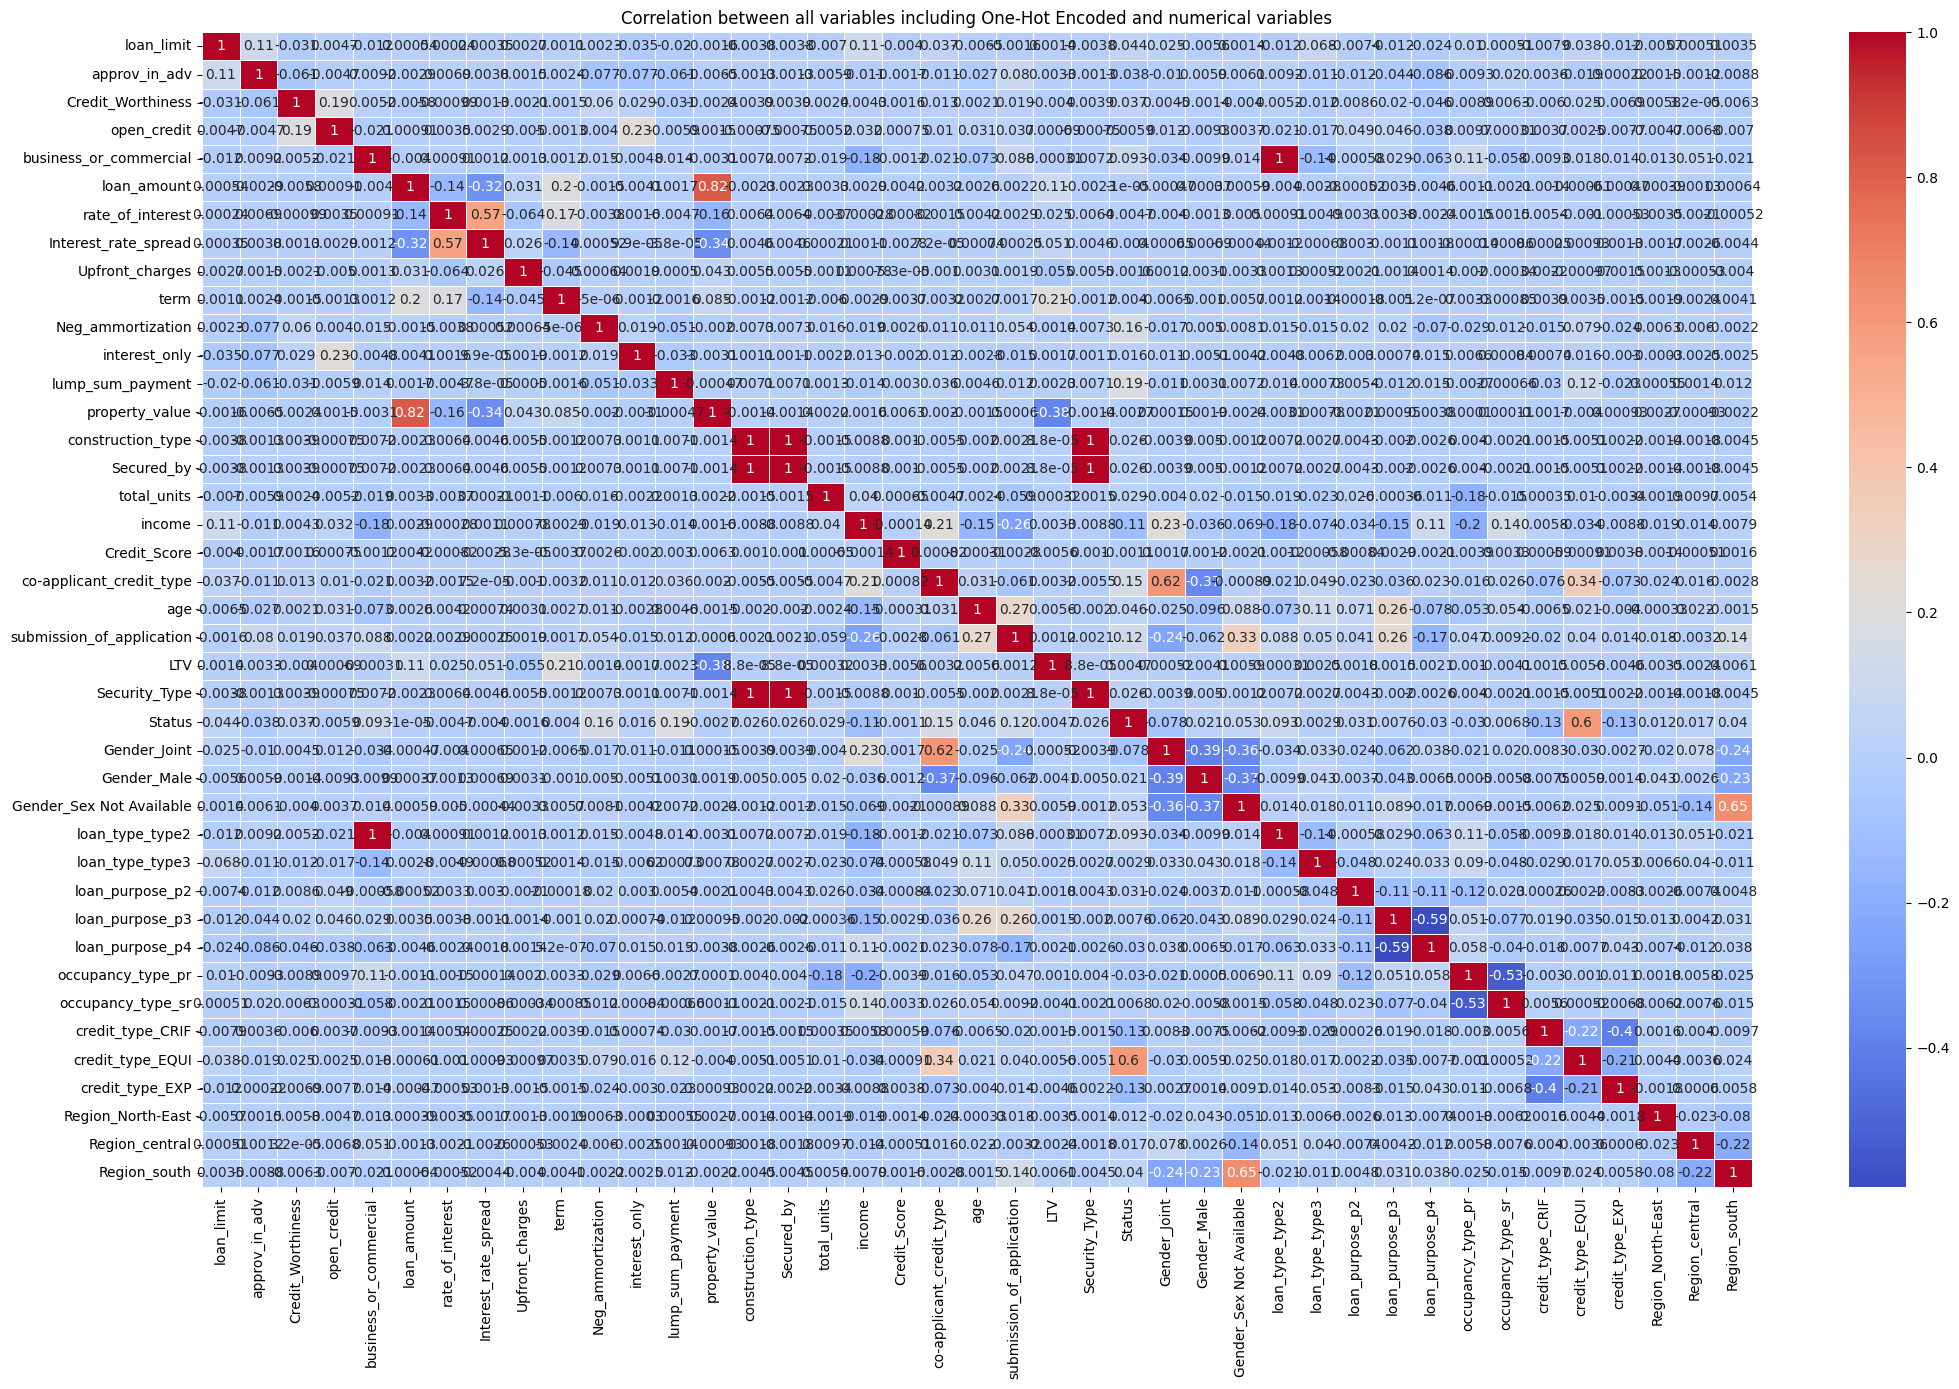

In [252]:
correlation_matrix = ds.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between all variables including One-Hot Encoded and numerical variables')
plt.show()

The following columns were removed from the dataset as they either had high correlation with each other or had little impact on predicting the target variable 'Status':

In [253]:
ds = ds.drop(['Region_central', 'Region_North-East', 'Region_south', 'Interest_rate_spread', 'Gender_Joint', 'Gender_Male', 
              'Gender_Sex Not Available', 'total_units', 'loan_purpose_p3', 'loan_purpose_p4', 'loan_purpose_p2', 'credit_type_EXP', 'term', 'credit_type_CRIF', 'occupancy_type_sr', 'loan_amount', 'Credit_Score', 'LTV', 'Upfront_charges', 'property_value', 'Secured_by', 'rate_of_interest', 'open_credit', 'Security_Type'], axis=1)

In [254]:
ds.columns

Index(['loan_limit', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'construction_type', 'income',
       'co-applicant_credit_type', 'age', 'submission_of_application',
       'Status', 'loan_type_type2', 'loan_type_type3', 'occupancy_type_pr',
       'credit_type_EQUI'],
      dtype='object')

In [255]:
# Save the modified DataFrame to a new CSV file
ds.to_csv('prepared_dataset.csv', index=False)

## Звіт про очищення даних

Виконав студент групи ОІ-35: Басала Валентин

У наборі даних було виявлено декілька типів шумів, а саме: аномальні та пропущені значення.

Аномальні значення зустрічалися у таких стовпцях, як income, property_value та LTV, ці значення відхилялися від середнього рівня (завелика цінність майна, завеликий дохід, LTV має значення більше 100 %).

Відсутні значення зустрічалися у багатьох стовпцях, а саме: 
loan_limit (мало 2877 пропущених значень),
approv_in_adv (775),
loan_purpose (113),
rate_of_interest (19353),
Interest_rate_spread (19552),
Upfront_charges (22315),
term (27),
Neg_ammortization (105),
income (8786),
age (199),
submission_of_application (199).


Для всіх категоріальних стовпців (loan_limit, approv_in_adv, loan_purpose, Neg_ammortization, submission_of_application, age, Security_Type) використовувалася мода для заповнення пропущених значень, оскільки пропущених значень було небагато.

Для деяких числових стовпців (rate_of_interest, Interest_rate_spread, property_value, LTV, income) пропущені значення були заповнені медіанними значеннями, розрахованими в розрізі категорій інших змінних, з якими ці стовпці мають кореляцію. Такий підхід дозволив зберегти залежності між змінними та забезпечити більш точне заповнення пропусків.

Для числового стовпця term пропущені значення були заповнені медіанним значенням, оскільки пропущених значень було небагато.

Для числового стовпця Upfront_charges пропущені значення були заповнені випадковими значеннями, оскільки не було виявлено значущих кореляцій з іншими змінними. Це дозволило уникнути спотворення можливих залежностей у даних.

У стовпцях income, property_value аномальні значення були очищені шляхом видалення значень, що виходили за межі допустимих значень, визначених за допомогою інтерквартильного розмаху (IQR), а в стовпці LTV замінив аномальні значення на 100 (максимально можливе значення для відсотків).

Наступні стовпці були видалені з датасету, оскільки вони мали малий вплив на прогнозування Status: Unnamed: 0, ID, year, Region_central, Region_North-East, Region_south, Interest_rate_spread, Gender_Joint, Gender_Male, Gender_Sex Not Available, total_units, loan_purpose_p3, loan_purpose_p4, loan_purpose_p2, credit_type_EXP, term, credit_type_CRIF, occupancy_type_sr, loan_amount, Credit_Score, LTV, Upfront_charges, property_value, Secured_by, rate_of_interest, open_credit, Security_Type. Ці ознаки були видалені для спрощення моделі та підвищення її ефективності.